# Carvana U-Net Heng

## Imports

In [1]:
#from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.AdamAccumulate import AdamAccumulate
from models.u_net_heng import UNet_Heng
from utilities.submit import generate_submit
from utilities import utils_masks as utils
from utilities.losses import dice_value, weighted_bce_dice_loss

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


## Preparing Data

In [2]:
utils.set_results_reproducible()
input_size = 128
train_path = "inputs/train/{}.jpg" 
train_mask_path = "inputs/train_masks/{}_mask.gif"
df_train = pd.read_csv('inputs/train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])[:3000]
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

bboxes = None
#bbox_file_path = 'inputs/train_bbox.csv'
#bboxes = utils.get_bboxes(bbox_file_path)

def train_generator(batch_size):
    return utils.train_generator(train_path, train_mask_path, ids_train_split, input_size, batch_size, bboxes)

def valid_generator(batch_size):
    return utils.valid_generator(train_path, train_mask_path, ids_valid_split, input_size,batch_size, bboxes)

Training on 2400 samples
Validating on 600 samples


## Create Model

In [3]:
#FC-DenseNet56:
#model = Tiramisu((input_size, input_size, 3), growth_rate=12, depth=5, layers_per_block=[4,4,4,4,4,4]) 
#FC-DenseNet67:
#model = Tiramisu((input_size, input_size, 3), growth_rate=16, depth=5, layers_per_block=[5,5,5,5,5,5]) 
#FC-DenseNet103:
#model = Tiramisu((input_size, input_size, 3), growth_rate=16, depth=5, layers_per_block=[4,5,7,10,12,15]) 
#FC-DenseNet46 (Not in paper):
#model = Tiramisu((input_size, input_size, 3), growth_rate=12, depth=4, layers_per_block=[4,4,4,4,5]) 

#U-Net:
#model = UNet((input_size, input_size, 3), filters=128, depth=4, dropout_base_only=False, dropout=0,
#             activation=lambda x: PReLU()(x),
#             init='he_uniform')
#model.compile(optimizer=AdamAccumulate(accum_iters=4), loss=weighted_bce_dice_loss, metrics=[dice_value])

#U-Net-Heng:
model = UNet_Heng((input_size, input_size, 3))
model.compile(optimizer=AdamAccumulate(accum_iters=4), loss=weighted_bce_dice_loss, metrics=[dice_value])

## Fit Model

In [4]:
epochs = 50
batch_size = 16
run_name = utils.get_run_name('weights/{}.hdf5', 'unet-heng')
weights_path = 'weights/{}.hdf5'.format(run_name)

callbacks = [EarlyStopping(monitor='val_dice_value',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_value',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_value',
                             filepath=weights_path,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max'),
             TensorBoard(log_dir='logs/{}'.format(run_name), batch_size=batch_size)]

#model.load_weights('weights/unet-heng-2017-09-16-0946.hdf5')
#K.set_value(model.optimizer.lr, 1e-4)
#K.set_value(model.optimizer.momentum, 0.9)

print('Starting run "{}"'.format(run_name))
model.fit_generator(generator=train_generator(batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))

Starting run "unet-heng-2017-09-21-1132"
Epoch 1/50
150/150 [==============================] - 117s - loss: 0.8361 - dice_value: 0.8048 - val_loss: 0.7887 - val_dice_value: 0.8875
Epoch 2/50
150/150 [==============================] - 109s - loss: 0.7111 - dice_value: 0.9388 - val_loss: 0.7047 - val_dice_value: 0.9473
Epoch 3/50
150/150 [==============================] - 107s - loss: 0.6887 - dice_value: 0.9661 - val_loss: 0.6814 - val_dice_value: 0.9686
Epoch 4/50
150/150 [==============================] - 108s - loss: 0.6802 - dice_value: 0.9751 - val_loss: 0.6751 - val_dice_value: 0.9782
Epoch 5/50
150/150 [==============================] - 108s - loss: 0.6762 - dice_value: 0.9791 - val_loss: 0.6699 - val_dice_value: 0.9813
Epoch 6/50
150/150 [==============================] - 108s - loss: 0.6756 - dice_value: 0.9800 - val_loss: 0.6685 - val_dice_value: 0.9825
Epoch 7/50
150/150 [==============================] - 108s - loss: 0.6717 - dice_value: 0.9827 - val_loss: 0.6637 - val_dice_

## Validation

In [5]:
def np_dice_value(y_true, y_pred):
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

### Prediction

In [6]:
run_name = 'unet-2017-09-02-1809'
model.load_weights('weights/{}.hdf5'.format(run_name))

val_imgs, val_masks = next(valid_generator(len(ids_valid_split)))
val_imgs = np.array(val_imgs)
val_masks = np.array(val_masks)
val_pred_masks = model.predict(val_imgs, batch_size=1)
masks_val_dices = [np_dice_value(mask, pred_mask) for (mask, pred_mask) in zip(val_masks, val_pred_masks)]

### Display the worst predicted mask for validation examples

2cb06c1f5bb1_14 0.993128060848


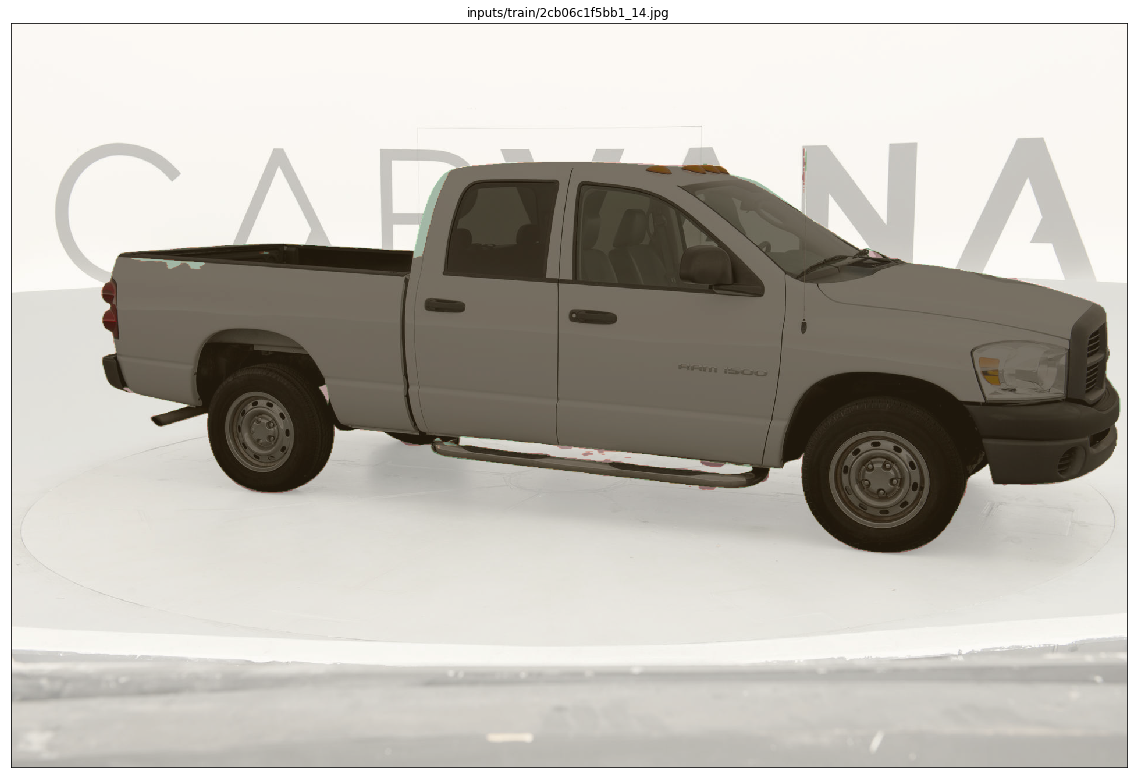

In [57]:
index = np.argsort(masks_val_dices)[15]
id = ids_valid_split.values[index]
utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(), show_img=True)
print id, masks_val_dices[index]

In [41]:
indices = np.argsort(masks_val_dices[masks_val_dices <= 99.6])
for id in indices:
        print(masks_val_dices[id])

0.996346765575


### Histogram

In [ ]:
hist, bins = np.histogram(masks_val_dices, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Visualization

In [ ]:
indices = np.random.randint(len(ids_valid_split), size=3)
for index in indices:
    id = ids_valid_split.values[index]
    utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(),
                    show_img=True, bbox = bboxes[id])

## Test

### Load Model

In [ ]:
# Create model first if required
run_name = 'unet-2017-08-20-5'
model.load_weights('weights/{}.hdf5'.format(run_name))

### Generate Submit

In [ ]:
batch_size = 16
threshold = 0.5
test_path = 'inputs/test1/' #'inputs/test/'
test_masks_path = 'outputs/test1_masks/' #None
generate_submit(model, input_size, batch_size, threshold, test_path, 'outputs/', run_name, test_masks_path)

### Visualization

In [ ]:
utils.show_test_masks(test_path, test_masks_path)